In [32]:

# This version is without chatGPT summarization just cosine 

In [25]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
from sentence_transformers import SentenceTransformer, util



/home/claney/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Unzipping csv file

In [2]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [3]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [4]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set


# Creating isDuplicate column

In [5]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_270736/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


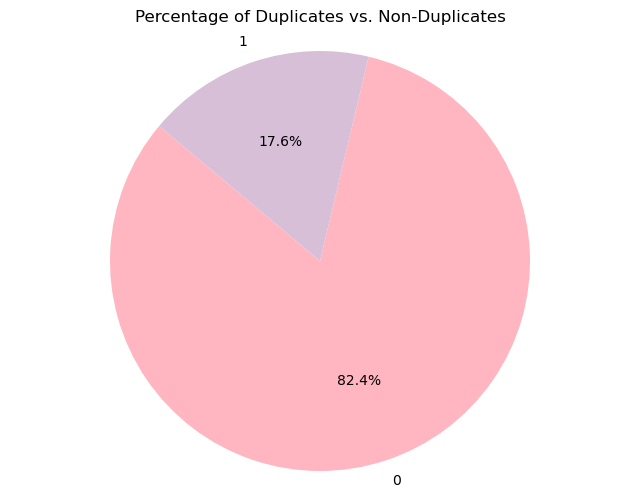

In [6]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [7]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_270736/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [8]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_270736/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_270736/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Creating topics using LDA

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

# Fit and transform the CountVectorizer on the text data
counts = count_vectorizer.fit_transform(df['full_text_data'])

count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
counts = count_vectorizer.fit_transform(df['full_text_data'])

        # Fit LDA model
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(counts)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [10]:
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-20 - 1:-1]]))
        
        print()

Topic 1:
framework junit dylib tests thread versions frameworks test com library apple testsuite 4xestacktrace libclient uitestapplication testresult testcase carbon 0010 remotetestrunner

Topic 2:
eclipse org core osgi update framework plugins message ui com jar bundle platform help equinox http ibm runtime apache entry

Topic 3:
swt new shell display line string public table int event import eclipse null object void org tree image item return

Topic 4:
lib eclipse 03 00000000 usr dll 00 object jar xp system32 org java windows lang plugins rwxp jre 08 02

Topic 5:
java org eclipse internal ui core swt run widgets main workbench jface display runtime lang method widget reflect launcher invoke

Topic 6:
editor text view open window line click dialog help search page menu select perspective tab does button ctrl editors right

Topic 7:
file project build eclipse new cvs error view workspace files use dialog using does bug problem create user set like



In [11]:
#for alll columns in the df 
#compare each bug report to each topic 
#if
topic_distributions = lda.transform(counts)

In [12]:
df['topic'] = topic_distributions.argmax(axis=1)

# Create DataFrames for each topic
topic_dfs = []
for topic_idx in range(7):
    topic_df = df[df['topic'] == topic_idx].copy()
    topic_dfs.append(topic_df)

# Display the DataFrames for each topic
for i, topic_df in enumerate(topic_dfs):
    print(f"Topic {i}:")
    print(topic_df['full_text_data'])
    print()

# Optionally, you can save each DataFrame to a CSV file
for i, topic_df in enumerate(topic_dfs):
    topic_df.to_csv(f'topic_{i}_bug_reports.csv', index=False)

/tmp/ipykernel_270736/2460893164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


Topic 0:
2735     Eclipse cannot display Japanese letters in the...
2736     Please see the following test result of NLSed ...
3320                                 This is a test PRTest
4775     The following entries in the org.eclipse.jface...
6971     There are no senders of ResourceState:storeSta...
                               ...                        
67512    In recent builds:; ; WIN XP; SUN 1.4.2; ; Wron...
67525    I have a java application that has been workin...
67599    1. Make a view a fast view.; 2. Click on the n...
67826     Simplification in ContentMergeViewer#setRight...
68048    I20080429-0100.; ; CachedMarkerBuilder writes ...
Name: full_text_data, Length: 275, dtype: object

Topic 1:
105      The ingore resources page has the list box far...
221      prefix        test; name          181178; refe...
222      prefix        test; name          181342; refe...
245      I created a new stream in the repository; made...
295      |     To:  Brian Young/OTT/OTI@OTI; Da

In [13]:
topic_0_df=pd.read_csv('topic_0_bug_reports.csv')
topic_1_df=pd.read_csv('topic_1_bug_reports.csv')
topic_2_df=pd.read_csv('topic_2_bug_reports.csv')
topic_3_df=pd.read_csv('topic_3_bug_reports.csv')
topic_4_df=pd.read_csv('topic_4_bug_reports.csv')
topic_5_df=pd.read_csv('topic_5_bug_reports.csv')
topic_6_df=pd.read_csv('topic_6_bug_reports.csv')


#storaging them in seperate csv so when we do classifciaton on them its alll seperate 

In [14]:
df['topic'] = topic_distributions.argmax(axis=1)
#adds column for topic to the df 


/tmp/ipykernel_270736/1678119556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


# Comparing the bug text using Cosine Similarity

# Refactoring

### Creating functions to test with different parameters

In [26]:
def getDuplicateBugIDS(threshold_value,topic_x_df): 
    import torch
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode sentences and store the embeddings in the DataFrame
    topic_x_df['embeddings'] = topic_x_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    # Convert embeddings to a tensor
    embeddings = torch.stack(topic_x_df['embeddings'].tolist())
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    numpy_array = cosine_scores.numpy()
    # Reshape the NumPy array into a matrix
    similarity_Matrix= numpy_array.reshape(cosine_scores.shape)
    similarity_Matrix= np.round(similarity_Matrix, decimals=4)
    # Function to filter rows based on condition
    def filter_matrix(matrix, threshold):
        filtered_matrix = []
        for row in matrix:
            if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
                filtered_matrix.append(row)
        return np.array(filtered_matrix)
    # Filtering the matrix
    filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)
    n = 0 #to iterate through
    topic_x_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
    while n < filtered_matrix.shape[0]:  # number of rows do this process to each row 
        matrix = filtered_matrix[n]
        def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
            result = np.where(matrix == 1.0)
            return result[0][0]  # Extract the first index directly
    
        def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
            condition = np.logical_and(matrix > threshold_value, matrix < 1)
            indices = np.argwhere(condition)
            return indices
        def get_duplicate_ids(matrix_indexs_of_duplicates):
            duplicate_ids = ""
            for row in matrix_indexs_of_duplicates:
                for element in row:
                    specific_row = topic_x_df.iloc[element]
                    duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
            return duplicate_ids
        index_in_df = find_position(matrix)  # index of selected bug
        specific_row = topic_x_df.iloc[index_in_df]  # selects bug row in dataframe
        duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
        topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
        n += 1  # to go through each row in the matrix
    return topic_x_df['Experimental_Duplicate_ID']

In [17]:
def accuracy(topic_x_df):
    #a match is considered if there are any matching values in exp_ids and dup_ids 
       # Split the IDs by spaces and strip whitespace
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(topic_x_df)
    return accuracy

In [34]:
def precision(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()
    #falsePositive is when the experimental duplicate id has a number but the actual one doesn't
    falsePositives = ((topic_x_df['Duplicated_issue'] == 0) & (topic_x_df['Experimental_Duplicate_ID'] != 0)).sum()
    precison= truePositive/(truePositive+falsePositives)
    return precison
    

In [19]:
def recall(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(topic_x_df['Experimental_Duplicate_ID'])
    actual_set = set(topic_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall

In [20]:
def f1(topic_x_df):
    recallVal=recall(topic_x_df)
    precisionVal=precision(topic_x_df)
    f1=2*((recallVal*precisionVal)/(precisionVal+recallVal))
    return f1

In [21]:
def experimentalisDuplicate(topic_x_df): #creates column for experimental binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    topic_x_df['isExperimentalDuplicate'] = topic_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return topic_x_df['isExperimentalDuplicate']

In [22]:
def binaryAccuracy(topic_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=topic_x_df['isExperimentalDuplicate']==topic_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(topic_x_df['isExperimentalDuplicate'])
    return accuracy

In [41]:
pip install pandas openpyxl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [44]:
topic_0_df.head(50)

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,isDuplicate,full_text_data,topic,embeddings,Experimental_Duplicate_ID,isExperimentalDuplicate
0,6135,P2,UI,0.0,NLS WSDD problems in IDE and VM - Japanese pro...,Eclipse cannot display Japanese letters in the...,CLOSED,FIXED,1.0,2001-11-20 17:49:00 -0500,2005-05-10 14:56:02 -0400,0,Eclipse cannot display Japanese letters in the...,0,"[tensor(-0.1554), tensor(-0.5071), tensor(-0.0...",6137,1
1,6137,P2,UI,0.0,NLS WSDD problems in IDE and VM - ASCII project,Please see the following test result of NLSed ...,CLOSED,FIXED,1.0,2001-11-20 17:54:00 -0500,2005-05-10 14:56:28 -0400,0,Please see the following test result of NLSed ...,0,"[tensor(-0.1815), tensor(-0.4352), tensor(-0.1...",6135,1
2,7394,P3,UI,0.0,Test,This is a test PR,RESOLVED,INVALID,1.0,2002-01-09 13:47:00 -0500,2002-01-21 21:29:19 -0500,0,This is a test PRTest,0,"[tensor(-0.2421), tensor(0.1078), tensor(-0.14...",0,0
3,10114,P3,Releng,0.0,NL: WSWB rollup 2 - Japanese translations have...,The following entries in the org.eclipse.jface...,CLOSED,FIXED,2.0,2002-02-22 14:45:00 -0500,2002-11-21 14:23:47 -0500,0,The following entries in the org.eclipse.jface...,0,"[tensor(-0.2245), tensor(0.0546), tensor(-0.16...",0,0
4,14461,P3,Team,0.0,Dav: No senders of ResourceState:storeState(),There are no senders of ResourceState:storeSta...,RESOLVED,FIXED,2.0,2002-04-23 18:14:00 -0400,2002-05-23 21:21:02 -0400,0,There are no senders of ResourceState:storeSta...,0,"[tensor(-0.1081), tensor(-0.3207), tensor(-0.0...",0,0
5,16868,P3,Resources,0.0,,,RESOLVED,INVALID,2.0,2002-05-22 11:40:00 -0400,2002-05-22 11:51:25 -0400,0,,0,"[tensor(0.1547), tensor(0.1800), tensor(0.0589...",0,0
6,17390,P3,SWT,0.0,JUnit testcases result for Graphics (1 error; ...,build 20020521; ; There are a large number of ...,RESOLVED,FIXED,2.0,2002-05-23 12:20:00 -0400,2002-05-30 16:37:57 -0400,0,build 20020521; ; There are a large number of ...,0,"[tensor(-0.3034), tensor(-0.0716), tensor(-0.0...",0,0
7,18124,P3,Team,0.0,FTPRemoteTargetResource should implement equal...,,RESOLVED,FIXED,2.0,2002-05-28 21:27:00 -0400,2002-05-29 12:08:29 -0400,0,FTPRemoteTargetResource should implement equa...,0,"[tensor(0.1220), tensor(0.2223), tensor(-0.432...",0,0
8,21177,P2,UI,0.0,[Tasks] Negative number of matched tasks,Eclipse 2.0; See on picture.; I think; tha...,RESOLVED,INVALID,2.0,2002-07-02 06:51:00 -0400,2003-02-10 12:52:44 -0500,0,Eclipse 2.0; See on picture.; I think; tha...,0,"[tensor(-0.3617), tensor(-0.1236), tensor(-0.1...",0,0
9,23135,P2,SWT,26563.0,Launching Update Manager crashes Eclipse (OSX ...,First of all; this bug may be because Im runni...,RESOLVED,DUPLICATE,2.0,2002-09-03 20:18:00 -0400,2002-11-20 07:15:35 -0500,1,First of all; this bug may be because Im runni...,0,"[tensor(-0.5914), tensor(-0.2035), tensor(-0.1...",0,0


In [47]:
sklearn.metrics.classification_report(topic_0_df["Duplicated_issue"].astype(str),topic_0_df['Experimental_Duplicate_ID'])

TypeError: '<' not supported between instances of 'int' and 'str'

In [48]:
print(topic_0_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Issue_id                   275 non-null    int64  
 1   Priority                   275 non-null    object 
 2   Component                  275 non-null    object 
 3   Duplicated_issue           275 non-null    float64
 4   Title                      275 non-null    object 
 5   Description                275 non-null    object 
 6   Status                     275 non-null    object 
 7   Resolution                 275 non-null    object 
 8   Version                    275 non-null    object 
 9   Created_time               275 non-null    object 
 10  Resolved_time              275 non-null    object 
 11  isDuplicate                275 non-null    int64  
 12  full_text_data             275 non-null    object 
 13  topic                      275 non-null    int64  

In [46]:
import sklearn

# Whole dataframe accuracy no topics

In [28]:
df_test=df.copy()

In [30]:
df_test['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,df_test)
whole_df_accuracy=accuracy(df_test)*100
experimentalisDuplicate(df_test)
whole_df_binary_accuracy=binaryAccuracy(df_test)*100
whole_df_recall=recall(df_test)
whole_df_precision=precision(df_test)
whole_df_f1=f1(df_test)
print(whole_df_accuracy)
print(whole_df_binary_accuracy)
print(whole_df_recall)
print(whole_df_precision)
print(whole_df_f1)

/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


77.90646468205038
79.33033879396395
0.8766166195926862
0.9407771120643812
0.9075643185102217


# Average accuracy 

In [51]:
import statistics
print(accuracyList)
accuracyListAverage=statistics.mean(accuracyList)
print(binaryAccuracyList)
binaryAccuracyListAverage=statistics.mean(binaryAccuracyList)
print(accuracyListAverage)
print(binaryAccuracyListAverage)

[69.0909090909091, 74.44735856125891, 83.9788089148703, 54.78142076502732, 52.54726511762159, 79.31759179132155, 82.75016031449522]
[70.18181818181817, 76.50805545147995, 84.38070880526124, 64.20765027322405, 61.466301053543084, 79.57720360984052, 82.98157080324532]
70.98764493650057
74.18618688263034


In [155]:
accuracyList=[69.0909090909091, 74.44735856125891, 83.9788089148703, 54.78142076502732, 52.54726511762159, 79.31759179132155, 82.75016031449522]
binaryAccuracyList=[70.18181818181817, 76.50805545147995, 84.38070880526124, 64.20765027322405, 61.466301053543084, 79.57720360984052, 82.98157080324532]

# MORE refactoring

In [35]:
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]

for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.85, df)
    accuracyVal = accuracy(df) * 100
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %69.09
Accuracy for topic 0 for duplicate or not is %70.18
Recall for topic 0 is %86.36
Precision for topic 0 is %79.17
F1 score for topic 0 is %82.61


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %74.45
Accuracy for topic 1 for duplicate or not is %76.51
Recall for topic 1 is %85.94
Precision for topic 1 is %86.17
F1 score for topic 1 is %86.05


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %83.98
Accuracy for topic 2 for duplicate or not is %84.38
Recall for topic 2 is %89.33
Precision for topic 2 is %95.33
F1 score for topic 2 is %92.24


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %54.78
Accuracy for topic 3 for duplicate or not is %64.21
Recall for topic 3 is %75.80
Precision for topic 3 is %81.67
F1 score for topic 3 is %78.63


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %52.55
Accuracy for topic 4 for duplicate or not is %61.47
Recall for topic 4 is %74.89
Precision for topic 4 is %69.84
F1 score for topic 4 is %72.28


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %79.32
Accuracy for topic 5 for duplicate or not is %79.58
Recall for topic 5 is %85.47
Precision for topic 5 is %97.77
F1 score for topic 5 is %91.20


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %82.75
Accuracy for topic 6 for duplicate or not is %82.98
Recall for topic 6 is %88.23
Precision for topic 6 is %98.28
F1 score for topic 6 is %92.99


 # Visualizations

In [36]:
# Initialize lists to store the results
accuracy_values = []
binary_accuracy_values = []
recall_values = []
precision_values = []
f1_values = []
topic_dfs = [topic_0_df, topic_1_df, topic_2_df, topic_3_df, topic_4_df, topic_5_df, topic_6_df]
# Perform the analysis and store the results
for x in range(7):
    df = topic_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.85, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %69.09
Accuracy for topic 0 for duplicate or not is %70.18
Recall for topic 0 is %86.36
Precision for topic 0 is %79.17
F1 score for topic 0 is %82.61


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %74.45
Accuracy for topic 1 for duplicate or not is %76.51
Recall for topic 1 is %85.94
Precision for topic 1 is %86.17
F1 score for topic 1 is %86.05


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %83.98
Accuracy for topic 2 for duplicate or not is %84.38
Recall for topic 2 is %89.33
Precision for topic 2 is %95.33
F1 score for topic 2 is %92.24


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %54.78
Accuracy for topic 3 for duplicate or not is %64.21
Recall for topic 3 is %75.80
Precision for topic 3 is %81.67
F1 score for topic 3 is %78.63


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %52.55
Accuracy for topic 4 for duplicate or not is %61.47
Recall for topic 4 is %74.89
Precision for topic 4 is %69.84
F1 score for topic 4 is %72.28


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %79.32
Accuracy for topic 5 for duplicate or not is %79.58
Recall for topic 5 is %85.47
Precision for topic 5 is %97.77
F1 score for topic 5 is %91.20


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_270736/4082931334.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %82.75
Accuracy for topic 6 for duplicate or not is %82.98
Recall for topic 6 is %88.23
Precision for topic 6 is %98.28
F1 score for topic 6 is %92.99


## Averages across topics

In [38]:
import statistics
print(statistics.mean(accuracy_values))
print(statistics.mean(binary_accuracy_values))
print(statistics.mean(recall_values))
print(statistics.mean(precision_values))
print(statistics.mean(f1_values))

70.98764493650057
74.18618688263034
83.71839799954952
86.8901106502925
85.14214113112307


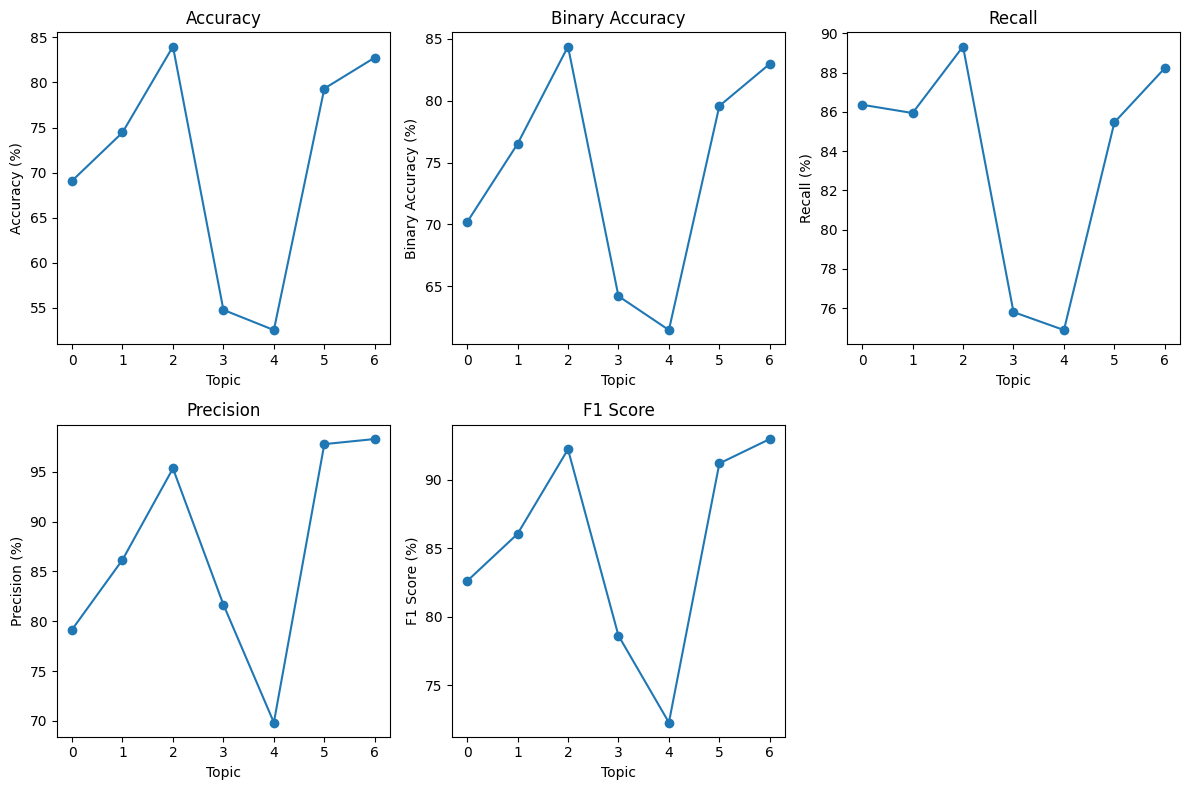

In [138]:
# Plot the results
topics = range(7)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(topics, accuracy_values, marker='o')
plt.title('Accuracy')
plt.xlabel('Topic')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 3, 2)
plt.plot(topics, binary_accuracy_values, marker='o')
plt.title('Binary Accuracy')
plt.xlabel('Topic')
plt.ylabel('Binary Accuracy (%)')

plt.subplot(2, 3, 3)
plt.plot(topics, recall_values, marker='o')
plt.title('Recall')
plt.xlabel('Topic')
plt.ylabel('Recall (%)')

plt.subplot(2, 3, 4)
plt.plot(topics, precision_values, marker='o')
plt.title('Precision')
plt.xlabel('Topic')
plt.ylabel('Precision (%)')

plt.subplot(2, 3, 5)
plt.plot(topics, f1_values, marker='o')
plt.title('F1 Score')
plt.xlabel('Topic')
plt.ylabel('F1 Score (%)')

plt.tight_layout()
plt.show()

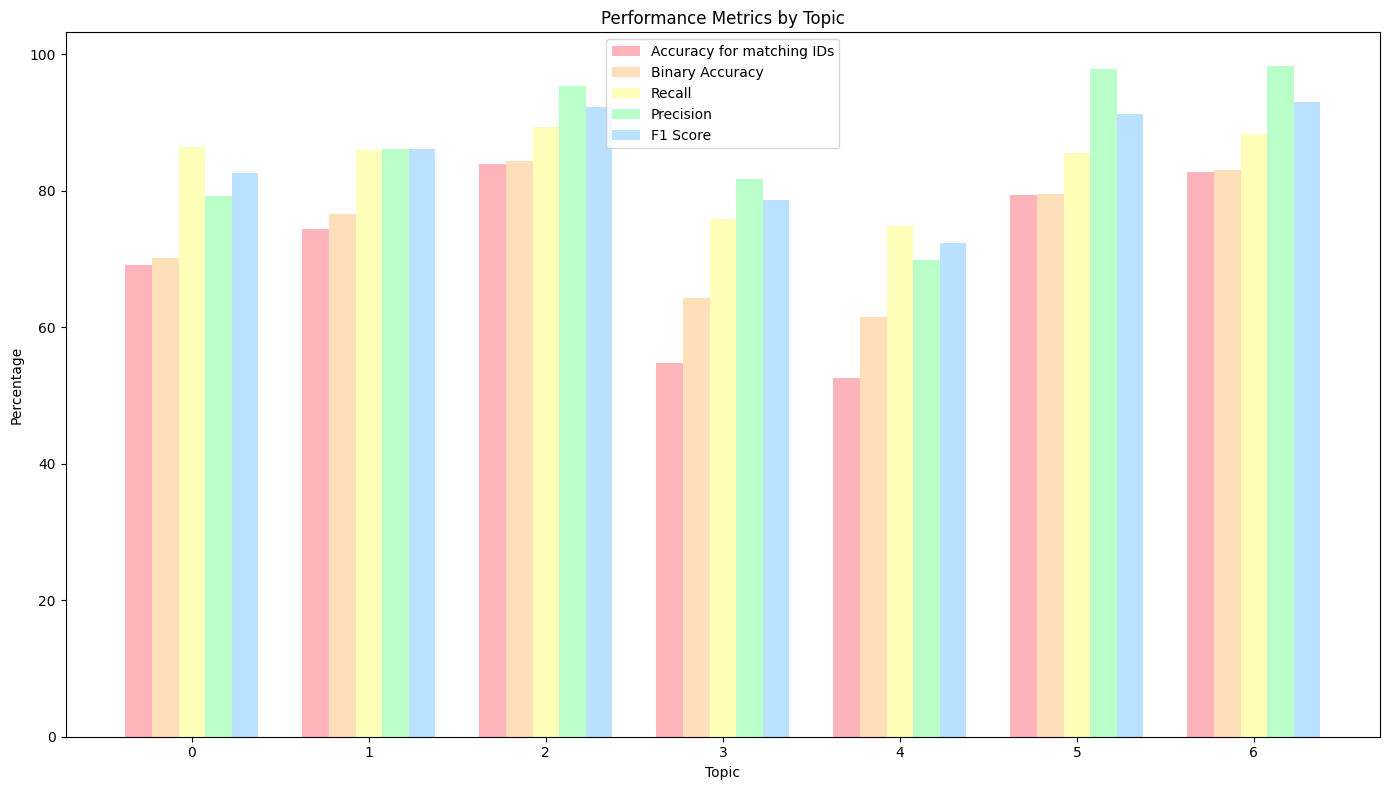

In [148]:
# Plot the results
topics = range(7)
bar_width = 0.15
index = np.arange(len(topics))

fig, ax = plt.subplots(figsize=(14, 8))

# Define pastel rainbow colors
colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']

bar1 = plt.bar(index, accuracy_values, bar_width, label='Accuracy for matching IDs', color=colors[0])
bar2 = plt.bar(index + bar_width, binary_accuracy_values, bar_width, label='Binary Accuracy', color=colors[1])
bar3 = plt.bar(index + 2 * bar_width, recall_values, bar_width, label='Recall', color=colors[2])
bar4 = plt.bar(index + 3 * bar_width, precision_values, bar_width, label='Precision', color=colors[3])
bar5 = plt.bar(index + 4 * bar_width, f1_values, bar_width, label='F1 Score', color=colors[4])

plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.title('Performance Metrics by Topic')
plt.xticks(index + 2 * bar_width, topics)
plt.legend(loc="upper center")

plt.tight_layout()
plt.show()

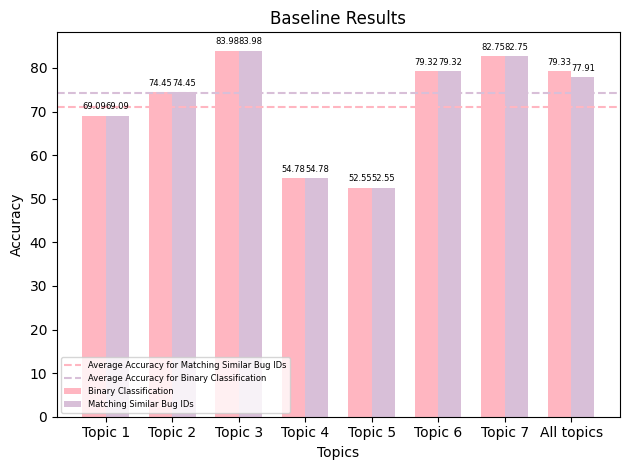

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'All topics']

accuracyList=[69.0909090909091, 74.44735856125891, 83.9788089148703, 54.78142076502732, 52.54726511762159, 79.31759179132155, 82.75016031449522]
binaryAccuracyList=[70.18181818181817, 76.50805545147995, 84.38070880526124, 64.20765027322405, 61.466301053543084, 79.57720360984052, 82.98157080324532]

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars
accuracyListwithAlltopics=accuracyList.copy()
binaryAccuracyListwithAlltopics=accuracyList.copy()
accuracyListwithAlltopics.append(whole_df_accuracy)
binaryAccuracyListwithAlltopics.append(whole_df_binary_accuracy)
fig, ax = plt.subplots()
bars_bug = ax.bar(x - width/2, binaryAccuracyListwithAlltopics, width, label='Binary Classification', color='#FFB6C1')
bars_bug_id = ax.bar(x + width/2, accuracyListwithAlltopics, width, label='Matching Similar Bug IDs', color='#D8BFD8')

# Calculate average values
accuracyListAverage = np.mean(accuracyList)
binaryAccuracyListAverage = np.mean(binaryAccuracyList)

# Plot average lines
ax.axhline(y=accuracyListAverage, color='#FFB6C1', linestyle='--', label='Average Accuracy for Matching Similar Bug IDs')
ax.axhline(y=binaryAccuracyListAverage, color='#D8BFD8', linestyle='--', label='Average Accuracy for Binary Classification')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Accuracy')
ax.set_title('Baseline Results')
ax.set_xticks(x)
ax.set_xticklabels(topics)

# Adding accuracy labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=6)  # Adjust font size here

add_labels(bars_bug)
add_labels(bars_bug_id)

# Make the legend smaller
ax.legend(loc='lower left', fontsize='small', prop={'size': 6})

plt.tight_layout()
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (8,).

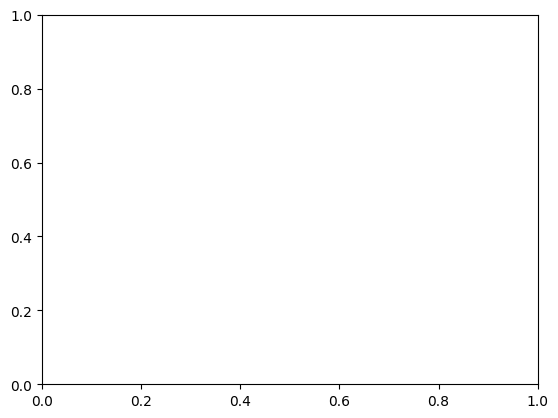

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']
accuracyList = [0.75, 0.82, 0.68, 0.80, 0.78, 0.85, 0.83, 0.81]  # Sample accuracy data for binary classification
binaryAccuracyList = [0.72, 0.79, 0.65, 0.77, 0.74, 0.82, 0.80, 0.78]  # Sample accuracy data for matching similar Bug IDs

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars_bug = ax.bar(x - width/2, accuracyList, width, label='Binary Classification', color='#FFB6C1')
bars_bug_id = ax.bar(x + width/2, binaryAccuracyList, width, label='Matching Similar Bug IDs', color='#D8BFD8')


# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Accuracy')
ax.set_title('Baseline Results')
ax.set_xticks(x)
ax.set_xticklabels(topics)

# Adding accuracy labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=6)  # Adjust font size here

add_labels(bars_bug)
add_labels(bars_bug_id)

# Make the legend smaller
ax.legend(loc='lower left', fontsize='small', prop={'size': 6})

plt.tight_layout()
plt.show()
